
# Implementação em Python - Regressão logística


Nessa aula, aprenderemos a montar na prática, utilizando Python, um modelo de regressão logística para realizar previsões. Como vimos a regressão logística é uma técnica estatística usada para modelar a probabilidade de um evento binário (por exemplo, sucesso/falha, sim/não).

# Nosso projeto:

Imagine que a empresa de carros que trabalhamos, tem capturado leads (formulárioss com informações) de todos clientes interessados que acessam o site da loja.
Então mesmo que o cliente não realize a compra, temos essas informações cadastradas.

O time de vendas nos pediu para criar um modelo que ao capturar as informações do cliente indique se ele tem uma alta probabilidade a compra do carro, para que um cupom de 5% salte na tela para esses clientes com maior propensão.
Caso o cliente não tenha, não receberá mensagem de desconto algum.
Abaixo temos a base dos leads já capturados para podermos treinar e testar nosso modelo!

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

In [ ]:
base = pd.read_csv("CARRO_CLIENTES.csv", delimiter=',')

In [ ]:
base

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0
...,...,...,...,...,...
995,863,Male,38,59000,0
996,800,Female,47,23500,0
997,407,Female,28,138500,1
998,299,Female,48,134000,1


Nossas colunas são:

**User ID** - Id do cliente cadastrado

**Gender** - Genero do cliente

**Age** - Idade do Cliente

**AnnualSalary** - Salário Anual

**Purchased** - Informação se o cliente comprou ou não carros na nossa loja.

Podemos notar que como estamos falando de uma base nova, teremos que realizar alguns passos de tratamento de dados, essa base pode conter dados nuloss, temos colunas categóricas, não está separada em treino e teste e nem X e Y.
Vamos brevemente realizar algumas verificações.

In [ ]:
# verificando tipos de dados e represença de nulos
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   User ID       1000 non-null   int64 
 1   Gender        1000 non-null   object
 2   Age           1000 non-null   int64 
 3   AnnualSalary  1000 non-null   int64 
 4   Purchased     1000 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


In [ ]:
# dropando a coluna de id que não necessitaremoss
base.drop(columns=['User ID'], inplace=True)

In [ ]:
# verificando se na coluna categorica (gender) temos algum valor escrito errado
base['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [ ]:
base.describe()

,Age,AnnualSalary,Purchased
count,1000.000000,1000.000000,1000.000000
mean,40.106000,72689.000000,0.402000
std,10.707073,34488.341867,0.490547
min,18.000000,15000.000000,0.000000
25%,32.000000,46375.000000,0.000000
50%,40.000000,72000.000000,0.000000
75%,48.000000,90000.000000,1.000000
max,63.000000,152500.000000,1.000000


Não parecemos ter uma forte presença de outliers, então seguiremos com o pré processamento.

# Análise das nossas variáveis:

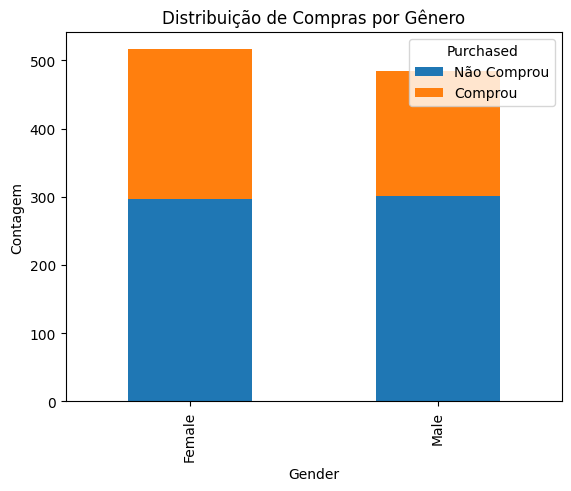

In [ ]:
# breve analise bivariada para conhecermos melhor nossos dados
contagem = pd.crosstab(base['Gender'], base['Purchased'])
contagem.plot(kind='bar', stacked=True)
plt.title('Distribuição de Compras por Gênero')
plt.xlabel('Gender')
plt.ylabel('Contagem')
plt.legend(title='Purchased', labels=['Não Comprou', 'Comprou'])
plt.show()

Maior parte dos clientes que deixaram cadastros são mulheres, assim como os clientesss que compraram.

In [ ]:
media_annual_salary = base.groupby('Purchased')['AnnualSalary'].mean()
print(media_annual_salary)

Purchased
0    62373.745819
1    88033.582090
Name: AnnualSalary, dtype: float64


Como esperado os clientes que compraram carross tem um salário anual relativamente maior.

In [ ]:
media_age = base.groupby('Purchased')['Age'].mean()
print(media_age)

Purchased
0    34.700669
1    48.146766
Name: Age, dtype: float64


Assim como clientes que compram os veiculos tendem a ter uma idade superior!

Para visualizarmos a matriz de correleção vamos transformar a variável gender (gênero) em variável numérica, pois está categórica.

In [ ]:
# Substituir os valores da coluna 'GENDER' por números específicos utilizando o replace
gender_mapping = {'Male': 0, 'Female': 1}
base['Gender'] = base['Gender'].replace(gender_mapping)

In [ ]:
base

,Gender,Age,AnnualSalary,Purchased
0,0,35,20000,0
1,0,40,43500,0
2,0,49,74000,0
3,0,40,107500,1
4,0,25,79000,0
...,...,...,...,...
995,0,38,59000,0
996,1,47,23500,0
997,1,28,138500,1
998,1,48,134000,1


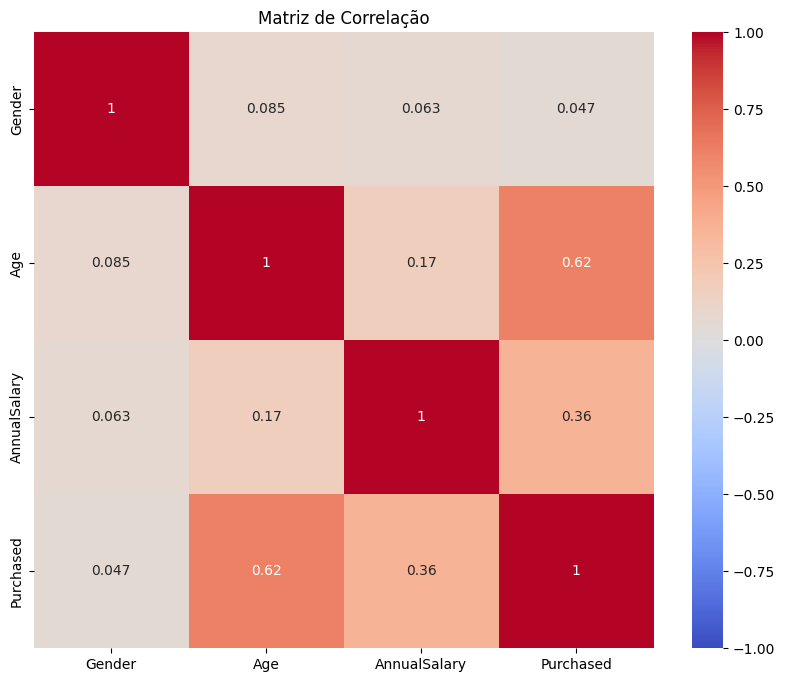

In [ ]:
correlation_matrix = base.corr()

# Plotando a matriz de correlação usando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

# Separando em X e Y:

In [ ]:
# Separando em X (variáveis de entrada) e Y (variável de saída)
X = base.drop('Purchased', axis=1)  # X contém todas as colunas exceto 'Purchased'
Y = base['Purchased']  # Y contém apenas a coluna 'Purchased'

# Verificando balanceamento do dados antes de separarmos em treino e teste:

In [ ]:
base['Purchased'].value_counts()

Purchased
0    598
1    402
Name: count, dtype: int64

# Separando base treino e teste:

In [ ]:
# Separar em base de treino e teste (usando 80% para treino e 20% para teste)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Padronizando Features

Há um motivo para a regressão logística ser mais sensível à escala das features em comparação com modelos baseados em árvores, como árvores de decisão.

* A regressão logística é um modelo linear. Ela tenta encontrar um plano de separação (hiperplano) no espaço das features para separar as classes.

* Como a regressão logística calcula um peso para cada feature, a escala das features pode afetar significativamente o treinamento. Features com valores maiores podem dominar a função de custo e os gradientes, levando a um modelo enviesado. Por isso, a padronização é importante para garantir que todas as features contribuam de forma equilibrada.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Inicializar StandardScaler
sc = StandardScaler()

# Ajustando e transformando os dados de treino
X_train = sc.fit_transform(X_train)

# Transformando os dados de teste usando os parâmetros aprendidos dos dados de treino
X_test = sc.transform(X_test)

# Balanceamento dos dados:

In [ ]:
# Balancear os dados de treinamento usando SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, Y_train_balanced = smote.fit_resample(X_train, Y_train)

Vamos verificar treino e teste:

In [ ]:
X_train_balanced

array([[ 0.96559161, -0.18027971,  2.15213703],
       [ 0.96559161,  1.78258424, -1.40762568],
       [-1.03563452, -0.46068884,  0.51696148],
       ...,
       [ 0.96559161,  1.25260948,  0.50914844],
       [-1.03563452,  1.06511164, -1.24376069],
       [-1.03563452, -0.42558321,  1.21705171]])

In [ ]:
Y_train_balanced

0      1
1      1
2      1
3      0
4      1
      ..
967    1
968    1
969    1
970    1
971    1
Name: Purchased, Length: 972, dtype: int64

In [ ]:
X_test

array([[-1.03563452,  0.10012943,  0.01049117],
       [-1.03563452,  1.78258424,  1.80484311],
       [-1.03563452, -1.39538596, -0.39468507],
       [ 0.96559161,  0.6609477 , -0.8866848 ],
       [ 0.96559161,  0.56747799,  1.80484311],
       [ 0.96559161,  1.22176597,  0.5024909 ],
       [-1.03563452,  1.40870539, -0.98797886],
       [ 0.96559161, -0.36721913, -0.29339101],
       [ 0.96559161,  0.10012943, -0.16315579],
       [-1.03563452, -0.74109798,  0.12625581],
       [ 0.96559161,  0.10012943,  0.09731465],
       [ 0.96559161, -1.11497682, -0.51044971],
       [ 0.96559161,  0.00665972,  0.27096161],
       [ 0.96559161, -0.46068884, -0.84327306],
       [-1.03563452,  0.94135683,  0.5024909 ],
       [-1.03563452,  0.47400828, -1.47997858],
       [-1.03563452,  0.6609477 , -0.87221422],
       [ 0.96559161,  1.40870539,  1.94954891],
       [ 0.96559161,  0.75441741,  1.32731396],
       [ 0.96559161, -1.86273452, -1.07480234],
       [-1.03563452, -0.36721913, -1.494

In [ ]:
Y_test

521    0
737    1
740    0
660    1
411    0
      ..
408    0
332    0
208    1
613    0
78     1
Name: Purchased, Length: 200, dtype: int64

# **Aplicando a regressão Logística!**

In [ ]:
# Utilizaremos a skleran
from sklearn.linear_model import LogisticRegression

# Iniciando Treinamento

Essa etapa é onde encontramos os coeficientes (parametros) da nossa equação.

In [ ]:
logistic_carro = LogisticRegression(random_state = 0)
# poderiamos adicionar max_iter = um valor. Ele controla o número máximo de vezes que o algoritmo itera sobre o conjunto de dados para encontrar os melhores coeficientes.

In [ ]:
logistic_carro.fit(X_train_balanced, Y_train_balanced)

LogisticRegression(random_state=0)

In [ ]:
logistic_carro.intercept_

array([-0.46345464])

In [ ]:
logistic_carro.coef_

array([[-0.22872152,  2.42205404,  1.28951364]])

Um valor para cada variável, como vimos na regressão linear multipla.

Nossa etapa de treinamento do modelo está completa, temos os coeficientes e podemos na próxima aula aplicar o teste e avaliar nosso modelo.


# Avaliação


In [ ]:
previsoes = logistic_carro.predict(X_train_balanced)

In [ ]:
relatorio = classification_report(Y_train_balanced, previsoes)
print("Relatório de Classificação:")
print(relatorio)

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       486
           1       0.85      0.83      0.84       486

    accuracy                           0.84       972
   macro avg       0.84      0.84      0.84       972
weighted avg       0.84      0.84      0.84       972



Vamos começar aplicando a base de treste nosso modelo!

In [ ]:
Y_pred_test = logistic_carro.predict(X_test)

In [ ]:
relatorio = classification_report(Y_test, Y_pred_test)
print("Relatório de Classificação:")
print(relatorio)

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       112
           1       0.76      0.74      0.75        88

    accuracy                           0.79       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.79      0.78       200



* A precisão de 0.76 para a classe 1 indica que 76% das instâncias que foram previstas como classe 1 realmente pertencem à classe 1.

* A revocação de 0.74 para a classe 1 indica que 74% das instâncias que pertencem à classe 1 foram corretamente identificadas pelo modelo.

* O F1-score de 0.75 para a classe 1 é a média harmônica da precisão e da revocação para a classe 1.

# CURVA AUC - ROC

**TPR - True Positive Rate**


**FPR - False Positive Rate**

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test)

# Calcular a AUC
roc_auc = roc_auc_score(Y_test, Y_pred_test)
print("AUC: {:.2f}".format(roc_auc))

AUC: 0.78


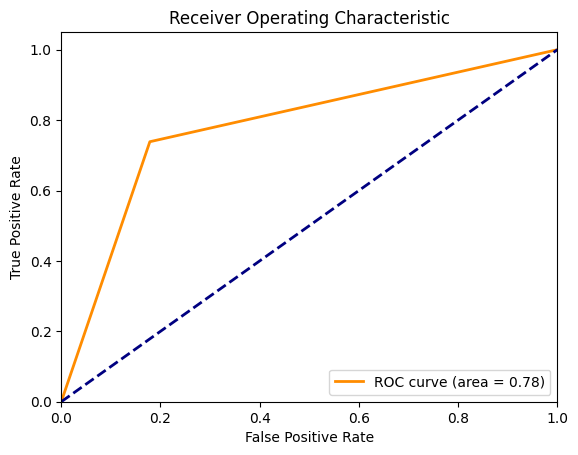

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()